<a href="https://colab.research.google.com/github/saivenkatreddy29/Medical-AI-Assistant/blob/main/Fine_tuning_LORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import heapq

items = [('v', -3), ('l', -1), ('o', -1)]
heapq.heapify(items)
max_heap = [(x, -y) for x, y in items]
print(f'max heap: {max_heap}')


max heap: [('l', 1), ('v', 3), ('o', 1)]


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-3.5-mini-instruct')
model = AutoTokenizer.from_pretrained('microsoft/phi-3.5-mini-instruct')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset,DataLoader
class CustomDatasets(Dataset):
  def __init__(self,input_text,
               labels,
               tokenizer,
               max_length_input,
               max_length_label):
    self.input_texts = input_text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length_input = max_length_input
    self.max_length_label = max_length_label

  def __len__(self):
    return len(self.input_texts)

  def __getitem__(self,idx):
    input_text = self.input_texts[idx]
    label_text = self.labels[idx]
    input_encodings = self.tokenizer(input_text,truncation = True, padding = 'max_length',max_length = self.max_length_input,return_tensors = 'pt')
    label_encodings = self.tokenizer(label_text,truncation = True, padding = 'max_length',max_length = self.max_length_label,return_tensors = 'pt')
    return {
    'input_ids': input_encodings['input_ids'].squeeze(0),
    'attention_mask': input_encodings['attention_mask'].squeeze(0),
    'label_ids': label_encodings['input_ids'].squeeze(0),
    'label_attention_mask': label_encodings['attention_mask'].squeeze(0)
}

In [ ]:
df = pd.read_csv("/content/Remedydata.csv")
df.head()

,did,diagnose,pid
0,1,Abdominal aortic aneurysm: (enlarged major blo...,Stopping smoking may slow their growth. Small ...
1,2,Abdominal swelling,Eating smaller meals may help prevent bloating...
2,3,Abdominal trauma,Surgery.
3,4,Abrasions: (scrapes),"Clean the wound(for mild abrasions), Surgery f..."
4,5,ACE inhibitor induced cough: blood pressure me...,Stopping the therapy in which ACE inhibitors a...


In [ ]:
input_text = df['diagnose'].to_numpy()

In [ ]:
input_text

array(['Abdominal aortic aneurysm: (enlarged major blood vessel)',
       'Abdominal swelling', 'Abdominal trauma', ...,
       'Invasive lobular carcinoma', 'Dystonia',
       'Failure to thrive - adult: failure to thrive'], dtype=object)

In [ ]:
input_label = df['pid'].to_numpy()
input_label[0]

'Stopping smoking may slow their growth. Small ones may only need monitoring. Aneurysms that are too large or growing too quickly should be repaired with surgery.'

Average length: 36.08
Median length: 35.00
Length range: 4 to 151


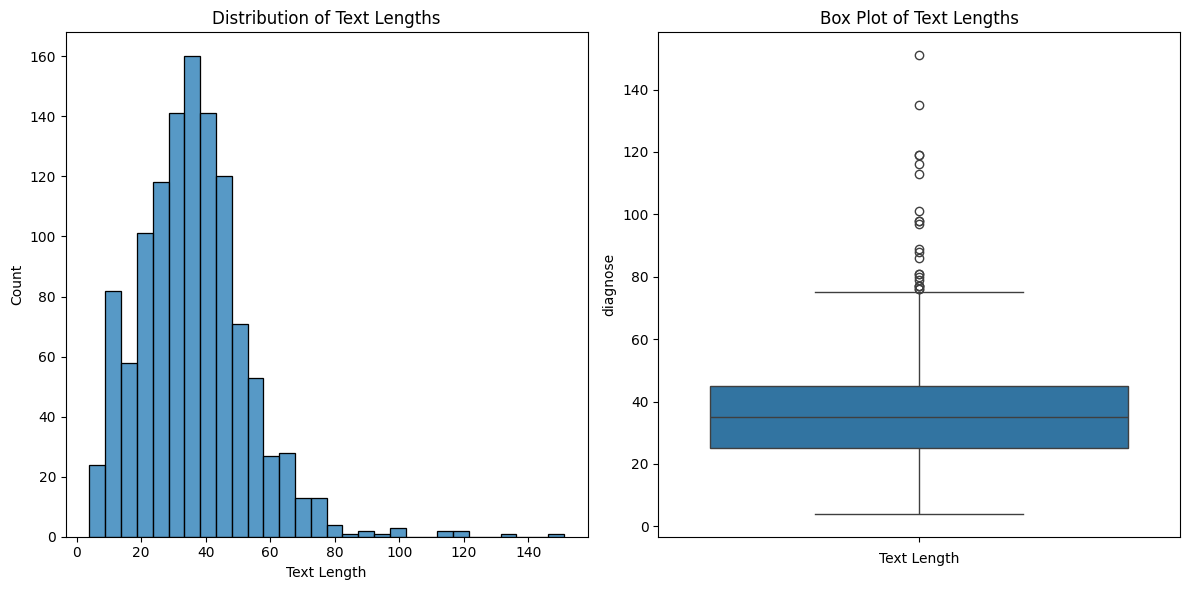

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, median, mode

def analyze_text_lengths(df, column_name):

    # Calculate lengths
    length_series = df[column_name].str.len()

    # Calculate statistics
    stats = {
        'mean_length': length_series.mean(),
        'median_length': length_series.median(),
        'min_length': length_series.min(),
        'max_length': length_series.max(),
        'std_dev': length_series.std()
    }

    # Create distribution plots
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=length_series, bins=30)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Count')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=length_series)
    plt.title('Box Plot of Text Lengths')
    plt.xlabel('Text Length')

    plt.tight_layout()

    return stats, length_series

# Example usage:
stats, lengths = analyze_text_lengths(df,'diagnose')
print(f"Average length: {stats['mean_length']:.2f}")
print(f"Median length: {stats['median_length']:.2f}")
print(f"Length range: {stats['min_length']} to {stats['max_length']}")

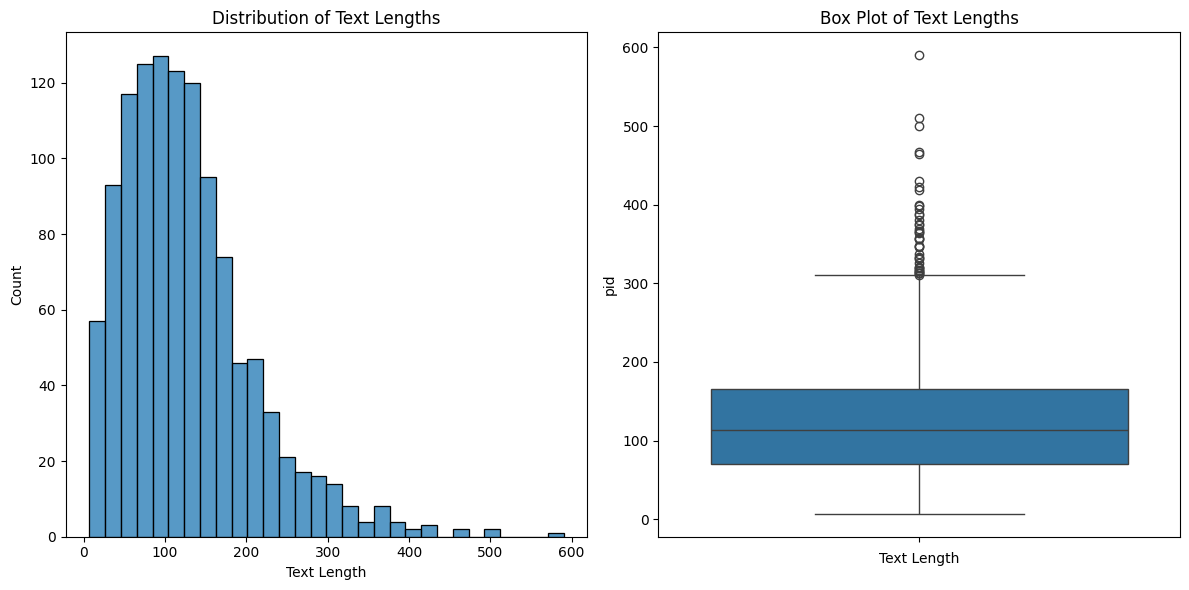

In [ ]:
stats, lengths = analyze_text_lengths(df,'pid')

In [ ]:
max_length_input = 65
max_length_label = 320
input_dataset = CustomDatasets(input_text = input_text,
                               labels = input_label,
                               tokenizer = tokenizer,
                               max_length_input = max_length_input,
                               max_length_label = max_length_label)

In [ ]:
input_dataset

In [ ]:
dataloader = DataLoader(input_dataset, batch_size = 32, shuffle = True)

In [ ]:
data_iter = iter(dataloader)
len(data_iter)

37

In [ ]:
sample = next(data_iter)

In [ ]:
len(sample['input_ids'])

32

In [ ]:
37*32

1184

In [ ]:
len(df)

1167

In [ ]:
sample

{'input_ids': tensor([[32000, 32000, 32000,  ..., 29901, 10416, 23900],
         [32000, 32000, 32000,  ...,  1090,   302,   737],
         [32000, 32000, 32000,  ..., 29901,   452,  1403],
         ...,
         [32000, 32000, 32000,  ..., 19309,   766,  2098],
         [32000, 32000, 32000,  ...,  1306,  4439,  5404],
         [32000, 32000, 32000,  ...,  4414,  4850,   362]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'label_ids': tensor([[32000, 32000, 32000,  ..., 24389,   362, 29889],
         [32000, 32000, 32000,  ...,   540,   284, 29889],
         [32000, 32000, 32000,  ..., 23900,   681,   467],
         ...,
         [32000, 32000, 32000,  ...,  1314,   273,   467],
         [32000, 32000, 32000,  ...,   347,   312, 16103],
         [32000, 32000, 32000,  ...,   652,   300, 

In [ ]:
class Lora(nn.Module):
  def __init__(self):
    super(Lora,self).__init__()
    self.rank = rank
    self.original_layer = original_layer
    self.loraA = nn.Linear()